In [1]:
import numpy as np
import math
import MaxLik as ML
import matplotlib.pyplot as plt

# Basic ideas of TNLCd tomography:

First, the TNLC device is calibrated to be able to prepare six particular polarization states (as close to H, V, D, A, R, and L polarization as possible). These states are accurately characterized. When an unknown polarization state impinges the TNLC device followed by a polarizer and a photodetector, the device performs a polarization projection to the particular state. Six detection responses are sequentially acquired for the corresponding calibrated states. The input polarization state could be easily retrieved by solving a set of resulting linear equations or, which is how we proceed, using the maximum-likelihood method.

In [2]:
sigma1 = np.array([[1., 0.], [0., -1.]])
sigma2 = np.array([[0., 1.], [1., 0.]])
sigma3 = np.array([[0., -1j], [1j, 0.]])
sigma = np.array([sigma1, sigma2, sigma3])

blochFromRho = lambda rho_ : np.real(np.array([
    np.trace(np.dot(rho_,sigma1)),
    np.trace(np.dot(rho_,sigma2)),
    np.trace(np.dot(rho_,sigma3))
]))

rhoFromBloch = lambda bloch_ : np.array([
    [1+bloch_[0], bloch_[1]-1j*bloch_[2]],
    [bloch_[1]+1j*bloch_[2], 1-bloch_[0]]
])/2.

In [3]:
#Idela HVDARL
H = np.array([[1],[0]])
V = np.array([[0],[1]])
D = 1/math.sqrt(2) * (H + V)
A = 1/math.sqrt(2) * (H - V)
R = 1/math.sqrt(2) * (H + 1j*V)
L = 1/math.sqrt(2) * (H - 1j*V)

idealStates = [H,V,D,A,R,L]
projList = ['H', 'V', 'D', 'A', 'R', 'L']

In [4]:
from scipy import linalg as LAS
def ReturnRho(jones):
    return (jones@np.transpose(np.conjugate(jones)))

def Fidelity(rho1,rho2):
    return math.pow(np.trace(LAS.sqrtm(LAS.sqrtm(rho1)@rho2@LAS.sqrtm(rho1))),2)

In [5]:
blochFromRho(ReturnRho(H))

array([1., 0., 0.])

# TN LCc model
## Fitted parameters

In [6]:
a = -7.82057;
b = 0.0761821;
c = 176.156;
d = -2.89523;
e = -2.86832;
phi = -5.15607;
theta = -2.58144;

## Logistic function

In [7]:
retfun = lambda u_ : a + (1/(b + np.exp(d - c * (u_ ** e))))
#Tvar funkce popisující závislost retardance na napětí, nyní již konzistentní s DP

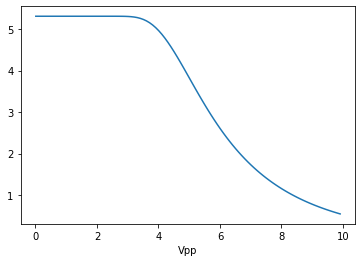

In [8]:
voltages = []
funcVal = []
for u in np.arange(0.01,10,0.1):
    voltages.append(u)
    funcVal.append(retfun(u))
    
plt.plot(voltages,funcVal)
plt.xlabel('Vpp')
plt.show()

## TN LCc matrix

In [9]:
lcmat = lambda u_: np.array([[np.cos(X(u_)) + (1j*gamma(u_) * np.sin(X(u_)))/X(u_), 
                            -((phi * np.sin(X(u_)))/X(u_))], 
                             [(phi * np.sin(X(u_)))/X(u_),
                            np.cos(X(u_)) - (1j * gamma(u_) * np.sin(X(u_))/X(u_))]])

#Finalni matice LCD

In [10]:
gamma = lambda u_: retfun(u_)
X = lambda u_ : np.sqrt((phi**2) + gamma(u_)**2)

In [11]:
#lcmat(0.1)
#lcmat(10)

### Total TN LCc matrix

In [12]:
rot = lambda x_ : np.array([[np.cos(x_), np.sin(x_)], [-np.sin(x_), np.cos(x_)]])
total = lambda u_ : rot(-theta)@rot(phi)@lcmat(u_)@rot(theta)

In [13]:
print (np.matrix(total(10.1)))

[[ 0.99575674-0.08794097j  0.02710254+0.00059889j]
 [-0.02710254+0.00059889j  0.99575674+0.08794097j]]


In [14]:
print (np.matrix(total(10.1)@total(10.1)@total(10.1))@H)

[[ 0.96202639-0.26084398j]
 [-0.08038953+0.00177637j]]


# Searching for target voltages
(random sampling)

In [15]:
TNLCd_prep = lambda u_: (total(u_[0])@total(u_[1])@total(u_[2])) #preparation

In [19]:
voltageList = []
statesList = []
for u1 in np.arange(0.1,10,0.25):
    for u2 in np.arange(0.1,10,0.25):
        for u3 in np.arange(0.1,10,0.25):
            voltageList.append([u1,u2,u3])
            statesList.append(TNLCd_prep([u1,u2,u3])@H)
rhoLis = []
for state in statesList:
    rhoLis.append(ReturnRho(state))

In [37]:
print (f'Approx time: {np.round(len(rhoLis)*15/60/60/24,2)}d')

Approx time: 11.11d


In [21]:
voltages = []
for target in idealStates:
    fidelList = []
    for rho in rhoLis:
        fidelList.append(Fidelity(rho,ReturnRho(target)))
    index = fidelList.index(max(fidelList))
    #print(index)
    print(max(fidelList))
    #print(voltageList[index])
    voltages.append(voltageList[index])

<ipython-input-4-6ebae919a181>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.pow(np.trace(LAS.sqrtm(LAS.sqrtm(rho1)@rho2@LAS.sqrtm(rho1))),2)


0.9999904276835496
0.9985774011905191
0.9999956388806959
0.9999776869008274
0.9999879481851178
0.9999301898334501


In [22]:
blochFromRho(ReturnRho(TNLCd_prep(voltages[0])@H))

array([ 0.99998086, -0.00541619, -0.00299237])

In [23]:
def Proj(argument):
    return(TNLCd_prep(argument)@H)

projectors = []
for proj in projList:
    voltage = voltages[projList.index(proj)]
    projectors.append(np.outer(Proj(voltage),Proj(voltage).conj()))

In [24]:
#Fidelity(ReturnRho(TNLCd_prep(voltages[0])@H),ReturnRho(H))

# Analysis

In [25]:
#analyzed state |IN>
inState = L

#number of photons used for analysis
photons = 100000

In [26]:
linPol = np.array([[1,0],[0,0]])

TNLCd_anal = lambda u_: (total(u_[2])@total(u_[1])@total(u_[0])) #Analysis

def OutState(argument):
    return(linPol@TNLCd_anal(argument)@inState)

In [27]:
#proj = 'H'
#outState = OutState(voltages[projList.index(proj)])
#print (outState)
#print (abs(np.transpose(np.conjugate(outState))@outState))

In [28]:
data = []

for proj in projList:
    outState = OutState(voltages[projList.index(proj)])
    data.append(abs(np.transpose(outState)@outState)[0][0])
    
#print (data)

In [29]:
prob = data/sum(data)
countData = np.random.multinomial(photons,prob) #photons per projection - all projections measured at the same time (model)

print ('Photons per proj.: ' + str(countData))

Photons per proj.: [16891 15355 16805 16691     0 34258]


## Maximum-likelihood

In [30]:
[rho,bloch] = ML.Maxlik(countData, projectors)

# Result

In [31]:
print ('Analyzed state: ' + str(bloch))
print ('|IN>:           ' + str(blochFromRho(ReturnRho(inState))))

Analyzed state: [ 0.00858685  0.00388988 -0.99995557]
|IN>:           [ 0.  0. -1.]
